#### Using RF-DETR for object detection
* Install necessary packages
* Load data
* Fix orientation for bad images
* Create COCO dataset
* Train model
* Evaluate model

In [1]:
!pip install -Uqq rfdetr pybboxes supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
import os
import json
import cv2
import math
import pandas as pd
import numpy as np
import pybboxes as pbx
import pybboxes.functional as pbf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from pathlib import Path
import supervision as sv
from tqdm.auto import tqdm
from rfdetr import RFDETRBase, RFDETRLarge
from PIL import Image, ImageDraw, ImageFont, ExifTags
from functools import lru_cache
from pprint import pprint
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import StratifiedGroupKFold

2025-04-25 07:42:34.694829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745566954.913621      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745566954.976277      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_path = Path('/kaggle/input/amini-cocoa-contamination-challenge/Amini Cocoa Contamination Challenge')

train_images_path = data_path / 'images/train'
train_labels_path = data_path / 'labels/train'
test_images_path = data_path / 'images/test'

read_csv = lambda x: pd.read_csv(str(data_path / x))

train = read_csv('Train.csv')
test = read_csv('Test.csv').fillna(0)
ss = read_csv('SampleSubmission.csv')

In [4]:
train.shape, test.shape, ss.shape

((9792, 9), (1626, 9), (1626, 7))

In [5]:
train.head()

Image_ID    class  confidence   ymin   xmin   ymax   xmax  class_id  \
0  ID_nBgcAR.jpg  healthy         1.0   75.0   15.0  162.0  195.0         2   
1  ID_nBgcAR.jpg  healthy         1.0   58.0    1.0  133.0  171.0         2   
2  ID_nBgcAR.jpg  healthy         1.0   42.0   29.0  377.0  349.0         2   
3  ID_Kw2v8A.jpg  healthy         1.0  112.0  124.0  404.0  341.0         2   
4  ID_Kw2v8A.jpg  healthy         1.0  148.0  259.0  413.0  412.0         2   

                            ImagePath  
0  dataset/images/train/ID_nBgcAR.jpg  
1  dataset/images/train/ID_nBgcAR.jpg  
2  dataset/images/train/ID_nBgcAR.jpg  
3  dataset/images/train/ID_Kw2v8A.jpg  
4  dataset/images/train/ID_Kw2v8A.jpg

In [6]:
test.head()

Image_ID  class  confidence  ymin  xmin  ymax  xmax  class_id  \
0  ID_Genxyu.jpg    0.0         0.0   0.0   0.0   0.0   0.0       0.0   
1  ID_svY6TG.jpg    0.0         0.0   0.0   0.0   0.0   0.0       0.0   
2  ID_d0gpda.jpg    0.0         0.0   0.0   0.0   0.0   0.0       0.0   
3  ID_frWmBT.jpg    0.0         0.0   0.0   0.0   0.0   0.0       0.0   
4  ID_TaRW6o.jpg    0.0         0.0   0.0   0.0   0.0   0.0       0.0   

                           ImagePath  
0  dataset/images/test/ID_Genxyu.jpg  
1  dataset/images/test/ID_svY6TG.jpg  
2  dataset/images/test/ID_d0gpda.jpg  
3  dataset/images/test/ID_frWmBT.jpg  
4  dataset/images/test/ID_TaRW6o.jpg

In [7]:
train['class'] = train['class'].str.strip()
class_map = {cls: i for i, cls in enumerate(sorted(train['class'].unique().tolist()))}
train['class_id'] = train['class'].map(class_map)

In [8]:
train['class'].value_counts()

class
healthy        4280
cssvd          3241
anthracnose    2271
Name: count, dtype: int64

In [9]:
train['class_id'].value_counts()

class_id
2    4280
1    3241
0    2271
Name: count, dtype: int64

In [10]:
train['ImagePath'] = train['ImagePath'].str.replace('dataset/images/train', str(train_images_path))
test['ImagePath'] = test['ImagePath'].str.replace('dataset/images/test', str(test_images_path))

In [11]:
@lru_cache(maxsize=None)
def get_image_dimensions(image_path):
    image_path = Path(image_path)
    image = Image.open(train_images_path / image_path)
    image = ImageOps.exif_transpose(image)
    width, height = image.size
    return width, height

   

# Helper function to get dimensions for each image in a DataFrame row
def get_dimensions_for_row(image_path):
    return get_image_dimensions(image_path)

# Apply function to DataFrame column using multithreading
def apply_dimensions_with_threads(df, column_name, max_workers=4):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Apply get_dimensions_for_row concurrently
        results = list(executor.map(get_dimensions_for_row, df[column_name]))
        
    # Extract width and height from results and add to DataFrame
    df[['width', 'height']] = pd.DataFrame(results, index=df.index)
    return df

In [12]:
train = apply_dimensions_with_threads(train, 'Image_ID', max_workers=os.cpu_count())

In [13]:
train[train.xmax > train.width]

Image_ID        class  confidence   ymin    xmin    ymax    xmax  \
431   ID_RUEBT5.jpg      healthy         1.0   27.0   303.0   139.0   417.0   
642   ID_SPyd52.jpg      healthy         1.0    1.0   165.0   172.0   417.0   
672   ID_JWGCGl.jpg      healthy         1.0   42.0   261.0   103.0   417.0   
775   ID_ofOgxi.jpg      healthy         1.0  137.0   244.0   360.0   417.0   
926   ID_c2XesD.jpg      healthy         1.0  269.0    82.0   416.0   417.0   
1204  ID_XbC4LO.jpg      healthy         1.0    5.0   112.0   416.0   417.0   
1210  ID_mKxmKN.jpg      healthy         1.0    3.0    27.0   416.0   417.0   
1401  ID_sAk119.jpg      healthy         1.0   63.0   175.0   163.0   417.0   
1873  ID_SxyKDH.jpg      healthy         1.0    1.0     1.0   416.0   417.0   
2635  ID_QpEPhk.jpg  anthracnose         1.0  496.0  1039.0  1087.0  1537.0   
2646  ID_lcd6Ng.jpg  anthracnose         1.0    1.0     1.0  2048.0  1537.0   
2647  ID_C9SxS3.jpg  anthracnose         1.0    3.0   178.0  2048.0  1537.0   
2649  ID_hkXJWR.jpg  anthracnose         1.0   15.0   498.0  2048.0  1537.0   
2689  ID_RBjLcg.jpg  anthracnose         1.0    6.0     1.0  2048.0  1537.0   
2780  ID_BBvYZW.jpg  anthracnose         1.0    1.0     1.0  2048.0  1537.0   
2865  ID_xK7CYQ.jpg  anthracnose         1.0    2.0     5.0  2048.0  1537.0   
2880  ID_syvdOd.jpg  anthracnose         1.0    1.0     1.0  2048.0  1537.0   
2882  ID_w0nbv5.jpg  anthracnose         1.0    8.0    19.0  2048.0  1537.0   
2996  ID_pluc1B.jpg  anthracnose         1.0    7.0     1.0  2048.0  1537.0   
3194  ID_WZXm3d.jpg  anthracnose         1.0   28.0   418.0  2048.0  1537.0   
3363  ID_LnI92V.jpg  anthracnose         1.0  272.0   440.0  2048.0  1537.0   

      class_id                                          ImagePath  width  \
431          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
642          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
672          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
775          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
926          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1204         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1210         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1401         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1873         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
2635         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2646         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2647         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2649         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2689         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2780         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2865         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2880         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2882         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2996         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
3194         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
3363         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   

      height  
431      416  
642      416  
672      416  
775      416  
926      416  
1204     416  
1210     416  
1401     416  
1873     416  
2635    2048  
2646    2048  
2647    2048  
2649    2048  
2689    2048  
2780    2048  
2865    2048  
2880    2048  
2882    2048  
2996    2048  
3194    2048  
3363    2048

In [14]:
train[train.ymax > train.height]

Image_ID        class  confidence   ymin   xmin    ymax    xmax  \
303   ID_CmbGmt.jpg      healthy         1.0   24.0    2.0   417.0   416.0   
1399  ID_sAk119.jpg      healthy         1.0  221.0   25.0   417.0   154.0   
1522  ID_LTHG5W.jpg      healthy         1.0    1.0    1.0   417.0   416.0   
1788  ID_FIJmp6.jpg      healthy         1.0  331.0    1.0   417.0   297.0   
1834  ID_y4Dveu.jpg      healthy         1.0   49.0    1.0   417.0   416.0   
2477  ID_tx3027.jpg  anthracnose         1.0    1.0    1.0  2049.0  1536.0   
2479  ID_JuC6hQ.jpg  anthracnose         1.0    1.0    1.0  2049.0  1536.0   
2502  ID_lPgVUk.jpg  anthracnose         1.0    1.0    1.0  2049.0  1536.0   
2653  ID_InwZDp.jpg  anthracnose         1.0  218.0   14.0  2049.0  1536.0   
2703  ID_k2TYY4.jpg  anthracnose         1.0    1.0    1.0  1537.0  2048.0   
2742  ID_A9j4mt.jpg  anthracnose         1.0  164.0  155.0  2049.0  1536.0   
2744  ID_A9j4mt.jpg  anthracnose         1.0  901.0  739.0  2049.0  1536.0   
2929  ID_dvP9fZ.jpg  anthracnose         1.0  395.0  186.0  2049.0  1536.0   
2951  ID_kcbyzy.jpg  anthracnose         1.0    1.0    1.0  2049.0  1536.0   
6517  ID_xn6J3u.jpg        cssvd         1.0  237.0    8.0  2049.0  1536.0   
6779  ID_eJPCkd.jpg        cssvd         1.0  879.0  342.0  2049.0   922.0   

      class_id                                          ImagePath  width  \
303          2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1399         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1522         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1788         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
1834         2  /kaggle/input/amini-cocoa-contamination-challe...    416   
2477         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2479         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2502         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2653         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2703         0  /kaggle/input/amini-cocoa-contamination-challe...   2048   
2742         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2744         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2929         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
2951         0  /kaggle/input/amini-cocoa-contamination-challe...   1536   
6517         1  /kaggle/input/amini-cocoa-contamination-challe...   1536   
6779         1  /kaggle/input/amini-cocoa-contamination-challe...   1536   

      height  
303      416  
1399     416  
1522     416  
1788     416  
1834     416  
2477    2048  
2479    2048  
2502    2048  
2653    2048  
2703    1536  
2742    2048  
2744    2048  
2929    2048  
2951    2048  
6517    2048  
6779    2048

In [15]:
@lru_cache(maxsize=None)
def get_image_dimensions(image_path):
    image_path = Path(image_path)
    image = Image.open(test_images_path / image_path)
    image = ImageOps.exif_transpose(image)
    width, height = image.size
    return width, height

   

# Helper function to get dimensions for each image in a DataFrame row
def get_dimensions_for_row(image_path):
    return get_image_dimensions(image_path)

# Apply function to DataFrame column using multithreading
def apply_dimensions_with_threads(df, column_name, max_workers=4):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Apply get_dimensions_for_row concurrently
        results = list(executor.map(get_dimensions_for_row, df[column_name]))
        
    # Extract width and height from results and add to DataFrame
    df[['width', 'height']] = pd.DataFrame(results, index=df.index)
    return df

In [16]:
test = apply_dimensions_with_threads(test, 'Image_ID', max_workers=os.cpu_count())

In [17]:
train['xmax'] = train['xmax'].clip(upper=train['width'])
train['ymax'] = train['ymax'].clip(upper=train['height'])

In [18]:
def annotate_image(image, coords, labels):
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf", size = 60)
    for coord, label in zip(coords, labels):
        draw.text(coord[:2], label.upper(), fill = 'red', font = font)
        draw.rectangle(coord, outline = 'black', width = 10)
    return image

In [19]:
def plot_images(train_df = train, images_path = train_images_path, ids=None, groupby_column='class', sample_size=5, figsize=(14, 6)):
    """
    Plots images from the train_df DataFrame based on provided IDs or sampled IDs.

    Parameters:
    - train_df: DataFrame containing the data.
    - images_path: Path object or string pointing to the directory containing images.
    - ids: A single ID (str), a list of IDs, or None. If None, samples IDs from the DataFrame.
    - groupby_column: Column name to group by for sampling (default is 'is_panel').
    - sample_size: Number of samples to take from each group if ids is None (default is 5).
    - figsize: Size of the figure (default is (14, 6)).
    """
    # If ids is not provided, sample IDs from the DataFrame
    if ids is None:
        selected_ids = train_df.groupby([groupby_column]).sample(sample_size).reset_index(drop=True).Image_ID.values.tolist()
        nrows, ncols = 2, 5  # Default grid size for sampled IDs
    else:
        # Ensure ids is a list
        selected_ids = [ids] if isinstance(ids, str) else ids
        num_images = len(selected_ids)
        ncols = min(5, num_images)  # Maximum of 5 columns
        nrows = math.ceil(num_images / ncols) + 1 # Adjust rows based on the number of images
        print(ncols, nrows)

    # Create subplots
    fig, axs = plt.subplots(figsize = figsize, nrows=nrows, ncols=ncols)
    axs = axs.flatten()
    
    # Turn off axes for all subplots
    for ax in axs:
        ax.axis('off')

    # Plot each image
    for i, file_id in enumerate(selected_ids):
        if i >= len(axs):  # Avoid index errors if there are more IDs than subplots
            break
        ax = axs[i]
        subset = train_df[train_df.Image_ID == file_id]
        image_path = (Path(images_path) / file_id)
        image = Image.open(image_path)
        image = ImageOps.exif_transpose(image)
        coords = subset[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
        labels = subset[groupby_column].values.tolist()
        annotated_image = annotate_image(image, coords, labels)
        ax.imshow(annotated_image.resize((1024, 1024)))
        ax.set_title(file_id)


    plt.tight_layout()
    plt.show()

In [20]:
train[train['Image_ID'] == 'ID_sZNOcT.jpg']

Image_ID        class  confidence   ymin   xmin    ymax    xmax  \
3342  ID_sZNOcT.jpg  anthracnose         1.0  437.0  597.0  4128.0  2524.0   

      class_id                                          ImagePath  width  \
3342         0  /kaggle/input/amini-cocoa-contamination-challe...   3096   

      height  
3342    4128

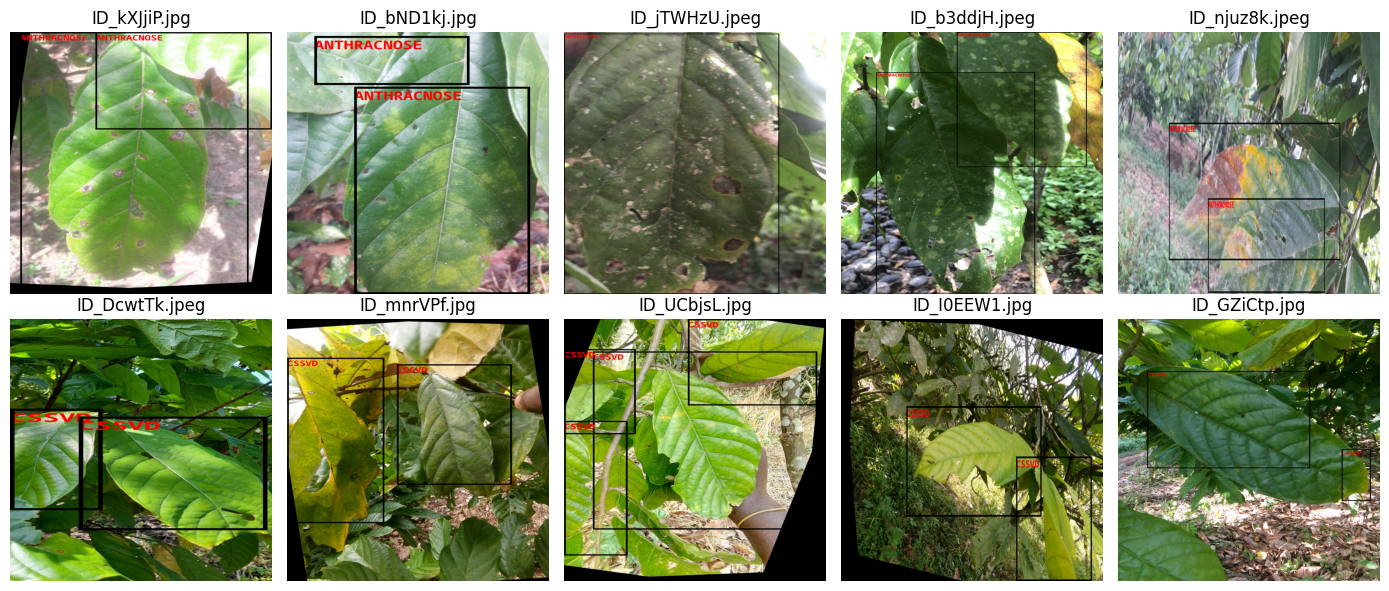

In [21]:
plot_images()

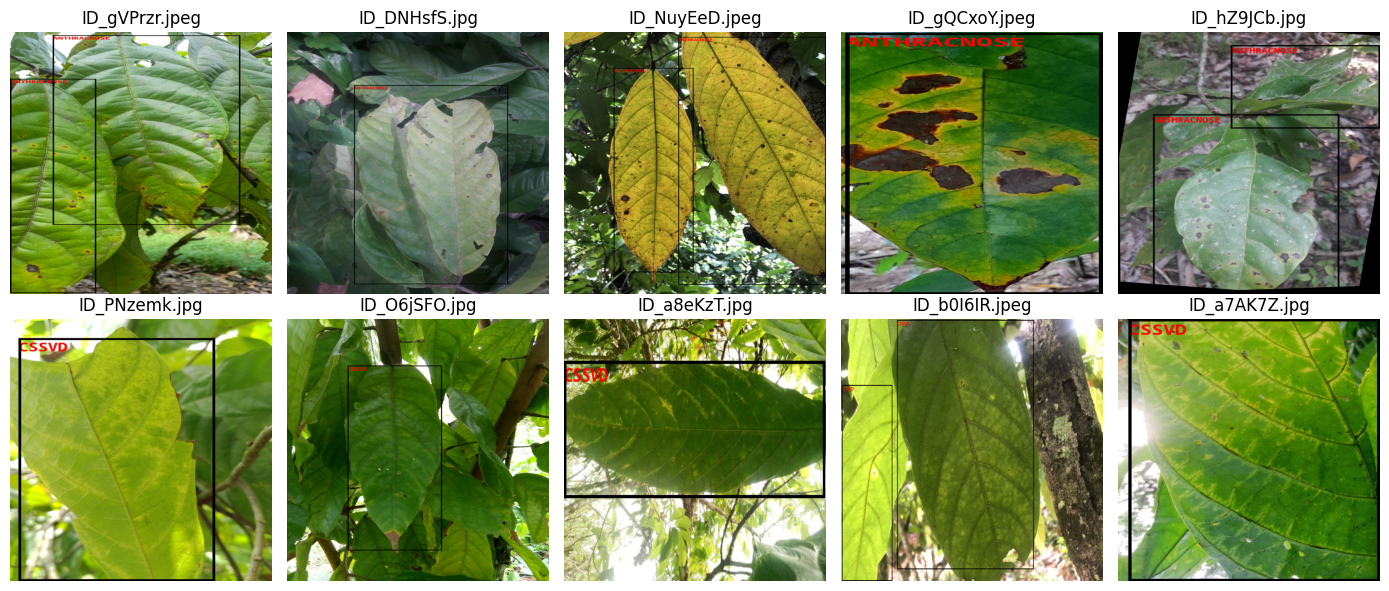

In [22]:
plot_images()

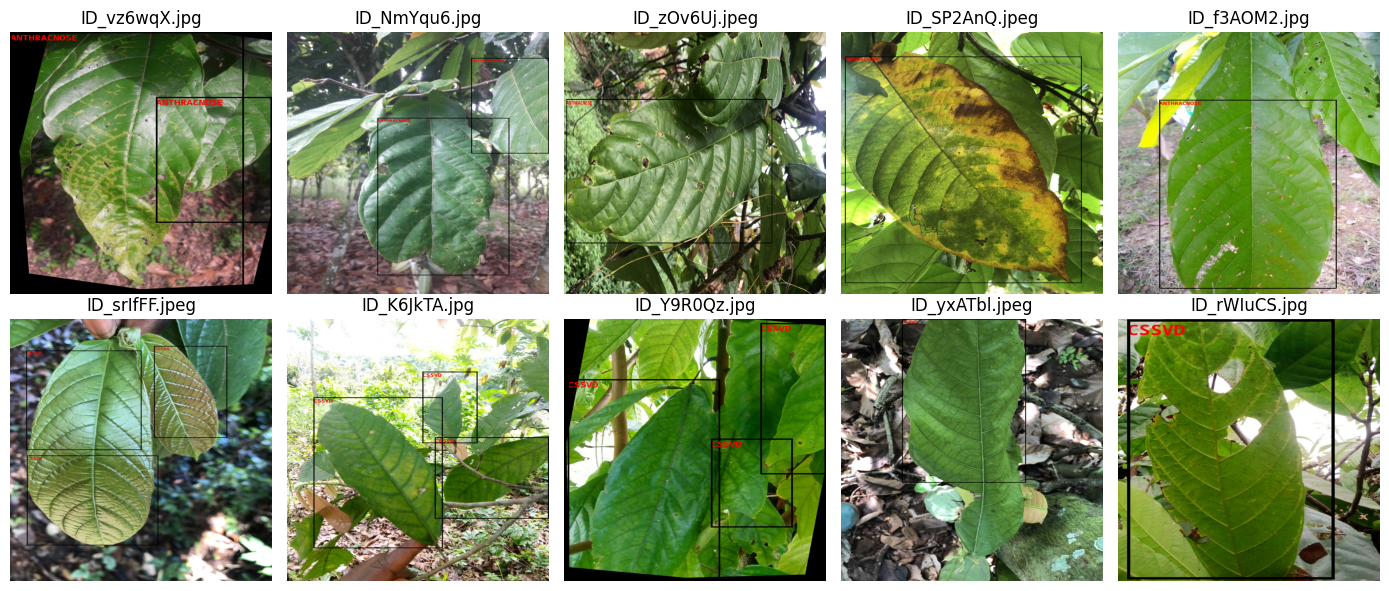

In [23]:
plot_images()

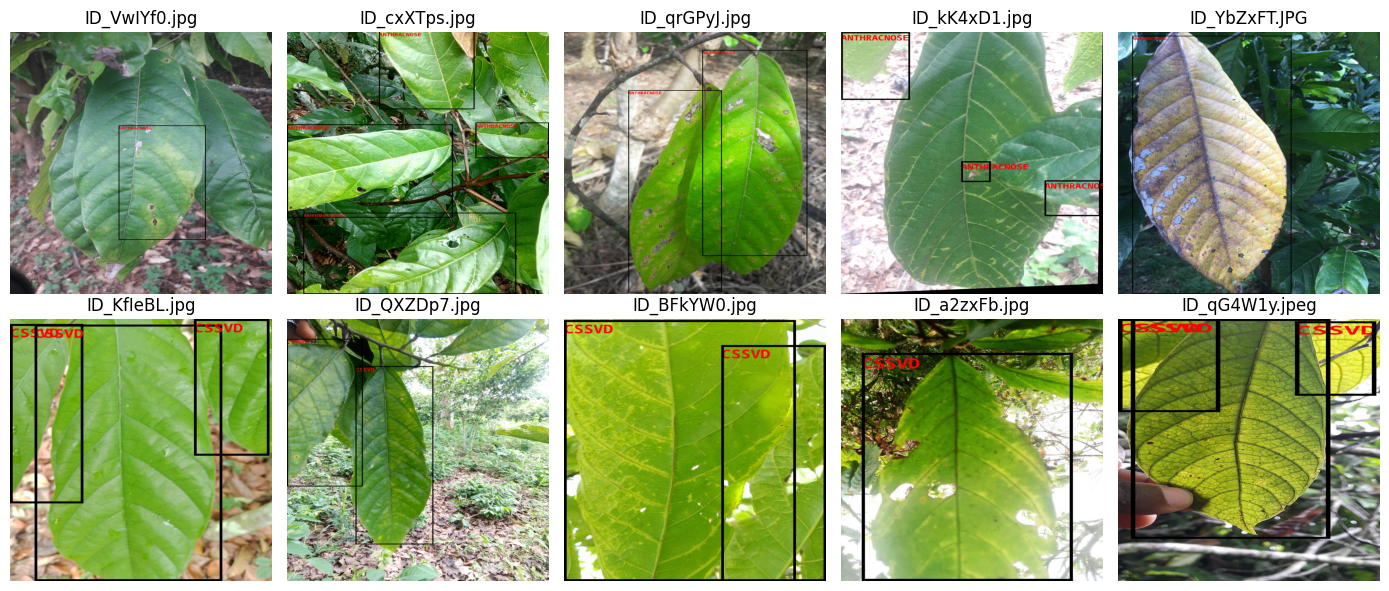

In [24]:
plot_images()

2 2


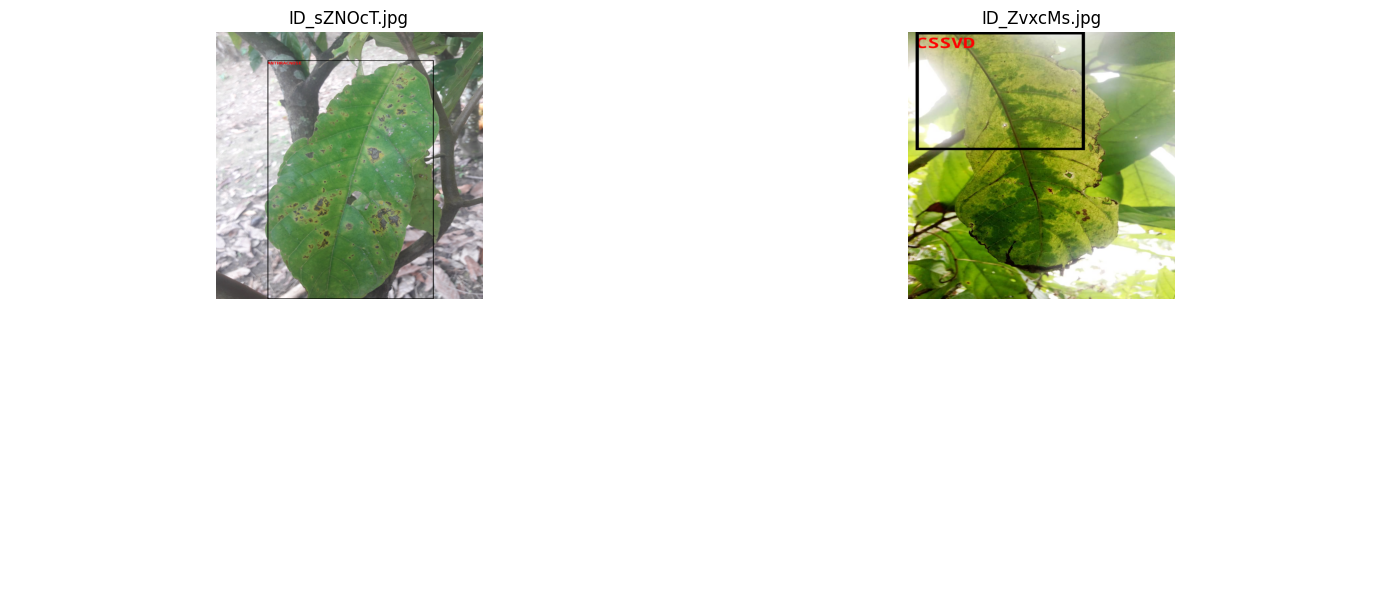

In [25]:
plot_images(ids = ['ID_sZNOcT.jpg', 'ID_ZvxcMs.jpg'])

#### Create COCO dataset


```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

In [26]:
#split data
skf = StratifiedGroupKFold(n_splits = 10, shuffle = True, random_state = 101)

train['fold'] = -1

for fold, (_, val_idx) in enumerate(skf.split(train, train['class_id'], groups = train['Image_ID'])):
    train.loc[val_idx, 'fold'] = fold

In [27]:
train_split = train[train.fold != 0]
val_split = train[train.fold == 0]

In [28]:
train.head()

Image_ID    class  confidence   ymin   xmin   ymax   xmax  class_id  \
0  ID_nBgcAR.jpg  healthy         1.0   75.0   15.0  162.0  195.0         2   
1  ID_nBgcAR.jpg  healthy         1.0   58.0    1.0  133.0  171.0         2   
2  ID_nBgcAR.jpg  healthy         1.0   42.0   29.0  377.0  349.0         2   
3  ID_Kw2v8A.jpg  healthy         1.0  112.0  124.0  404.0  341.0         2   
4  ID_Kw2v8A.jpg  healthy         1.0  148.0  259.0  413.0  412.0         2   

                                           ImagePath  width  height  fold  
0  /kaggle/input/amini-cocoa-contamination-challe...    416     416     1  
1  /kaggle/input/amini-cocoa-contamination-challe...    416     416     1  
2  /kaggle/input/amini-cocoa-contamination-challe...    416     416     1  
3  /kaggle/input/amini-cocoa-contamination-challe...    416     416     5  
4  /kaggle/input/amini-cocoa-contamination-challe...    416     416     5

In [29]:
def create_coco_subset(src_images_path, data_path, df, subset):

    images_path = data_path / f'{subset}'
    os.makedirs(images_path, exist_ok = True)
    
    annotations_save_path = (images_path / '_annotations.coco.json')
    annotations = dict()
    annotations['categories'] = [{
        'supercategory' : 'none',
        'id' : value,
        'name' : key
    } for key, value in class_map.items()
                                ]
    annotations['images'] = list()
    annotations['annotations'] = list()
    
    for i, image_id in tqdm(enumerate(df.Image_ID.unique()), total = df.Image_ID.nunique()):
        image_save_path = (images_path / image_id)
        subset = df[df.Image_ID == image_id]
        image_path = (src_images_path / image_id)
        image = Image.open(image_path).convert('RGB')
        image = ImageOps.exif_transpose(image)
        image.save(image_save_path)
        annotations['images'].append({
            'id' : i,
            'file_name' : image_id,
            'height' : int(subset.iloc[0]['height']),
            'width' : int(subset.iloc[0]['width'])
        })
        for j, row in subset.iterrows():
            category_id = row['class_id']
            voc_coords = row[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
            coco_coords = pbx.convert_bbox(voc_coords, from_type="voc", to_type="coco")
            area = pbf.compute_area(coco_coords, bbox_type="coco")
            area = int(area)
            annotations['annotations'].append({
                'id' : j,
                'image_id' : i,
                'category_id' : category_id,
                'bbox': list(coco_coords),
                'area' : area,
                'segmentation' : [],
                'iscrowd' : 0
            })      
    with open(annotations_save_path, 'w') as f:
        json.dump(annotations, f)

In [30]:
def create_coco_dataset(train, val, src_images_path):
    
    data_path = Path('amini cocoa disease coco dataset')
    os.makedirs(data_path, exist_ok = True)
    
    create_coco_subset(src_images_path, data_path, train, 'train')
    create_coco_subset(src_images_path, data_path, val, 'valid')

In [31]:
create_coco_dataset(train_split, val_split, Path('/kaggle/input/amini-cocoa-contamination-challenge/Amini Cocoa Contamination Challenge/images/train'))

  0%|          | 0/4977 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]